copied from  

RunModel_IntervalTracks_to_KDE_26Aug2022_HalfDozen_iter5A-testing-200epochs-2em5_fullLHCbMC-scrubbed_data.ipynb

modified to use the output from that learnng as starting point and learn for 10  more iterations as a test that "everything still works".

--------

Derive iter4A from iter#A.  Mostimportant changes -- used "scrubbed" data files in which events with
problematic KDEs have been removed and use 250 tracks per event rather than 150 as the long tail
creates some high-cost intervals.

Derive iter3A from iter2A; NB that collect_t2kde_data in in collectdata_kde_Ellipsoids_aug2022.py has (this morning) been modified to store only kernel info as labels, not xMax or Ymax info

----------------------------------

Derive iter2A from iter1A: RunModel_IntervalTracks_to_KDE_17Aug2022_HalfDozen_iter1A-testing-50epochs-2em5_fullLHCbMC 


Derive iter1 from iter0; start wherre iter0 left off and comment out code tht resets biases when starting


------------------------------
 
 

This is a copy of 

  RunModel_IntervalTracks_to_KDE_08Aug2022_HalfDozen_iter0-testing-50epochs-1em4_repeat
  
modified to use full LHCb MC rather than toy MC.  This requires changing the train_loader and val_loader input file and using a version of collectdata that "scrubs" the poca_ellipsoid data

 -------------------------------------------------

basically, a copy  of 

  RunModel_IntervalTracks_to_KDE_15July_HalfDozen_iter0-testing-50epochs-1em4

to see if those results are reproducible.  The only two changes are

   (i)  use gpu(2) rather than gpu(0)
   (ii) for val_loader, use slice=xxx

In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


In [2]:
import numpy as np
##  testing the np.floor and np.int_ methods as they seem to fail in a method used below
##  from model.collectdata_kde_Ellipsoids_29Aug2021 import collect_t2kde_data
print("np.version.version = ",np.version.version)
a = np.array([-1.7, -1.5, -0.2, 0.2, 1.5, 1.7, 2.0])
aFloor = np.floor(a)
print("a = ",a)
print("a.shape = ",a.shape)
print("aFloor = ",aFloor)
print("aFloor.shape = ",aFloor.shape)
aFloorInt = np.int_(aFloor)
print("aFloorInt = ",aFloorInt)

np.version.version =  1.21.1
a =  [-1.7 -1.5 -0.2  0.2  1.5  1.7  2. ]
a.shape =  (7,)
aFloor =  [-2. -2. -1.  0.  1.  1.  2.]
aFloor.shape =  (7,)
aFloorInt =  [-2 -2 -1  0  1  1  2]


This notebook is the second (perhaps third) attempt to read in track information and use it to predict the KDE used as input to pv-finder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_Ellipsoids.py uses poca_z, poca_x, poca_y, and six parameters A, B, C, D, E, and F describing the error ellipsoids are those defined at

from https://math.stackexchange.com/questions/1865188/how-to-prove-the-parallel-projection-of-an-ellipsoid-is-an-ellipse

Up to translation, a general ellipsoid can be written in the form

  𝐴$𝑥^2$ +𝐵$𝑦^2$+𝐶$𝑧^2$+2(𝐷𝑥𝑦+𝐸𝑥𝑧+𝐹𝑦𝑧)=1
  
for some positive-definite coefficient matrix 

$$
\left(\begin{array}{ccc}
A & D & E \\
D & B & F \\
E & F & C \\
\end{array}\right)
$$

Note that other conventions use a similarly named set of parameters with D, E, and and F denoting the coefficients of different combinations of $ x y $, etc., or without the factor of 2 in front of the cross-terms.  However, this is the convention we are using for pv-finder related work, as of early November, 20020


Check the current GPU usage. Please try to be nice!

In [3]:
!nvidia-smi

Wed Jul 19 20:59:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      On   | 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0    32W / 250W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-PCIE-40GB      On   | 00000000:25:00.0 Off |                    0 |
| N/A   

In [4]:
import torch
print(torch.__version__)
print(torch.cuda)

1.10.1+cu111
<module 'torch.cuda' from '/data/home/sokoloff/.local/lib/python3.8/site-packages/torch/cuda/__init__.py'>


> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("numpy.version.version = ",np.version.version)
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

numpy.version.version =  1.21.1


### Set up local parameters

In [6]:
n_epochs = 10

# Name is the output file name


##  201019  mds
folder = '19July2023_testing_HalfDozen_first_learning_iter6A_10epochs_2em5_fullLHCbMC_scrubbedData'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)

## batch_size = 64 seems to use 20 GB on 3090,
## so set batch_size = 16 so we can run on a 2080Ti
##  batch_size 16 still seems to require commenting out
##  device=device, and one epoch takes >900 seconds
##  compared to 120 seconds with batch_size = 64 on 3090
##  so try batch_size = 64 again
# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 2e-5

Make the output directory if it does not exist:

In [7]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [8]:
from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data as collect_t2kde_data_down
from model.collectdata_kde_Ellipsoids_MinBiasMagUp_14Nov import collect_t2kde_data as collect_t2kde_data_up

## 220714 mds 
## interval_kde_loss_Ba is derived from kde_loss_Ba, modified for 100-bin intervals
## looks like it returns average loss per bin, so costs may be directly
## comparable to original DirtyDozen
from model.interval_kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [9]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [10]:
##device = "cuda"
device = select_gpu(2)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 A100-PCIE-40GB


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [12]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-6, debug=False)
loss = Loss(epsilon=3e-6)

ct, child =  0    Linear(in_features=9, out_features=20, bias=True)
ct, child =  1    Linear(in_features=20, out_features=20, bias=True)
ct, child =  2    Linear(in_features=20, out_features=20, bias=True)
ct, child =  3    Linear(in_features=20, out_features=20, bias=True)
ct, child =  4    Linear(in_features=20, out_features=20, bias=True)
ct, child =  5    Linear(in_features=20, out_features=100, bias=True)


Let's move the model's weight matricies to the GPU:

In [13]:
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
##updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
##updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
##updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
##updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
##updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()

output =  ML/19July2023_testing_HalfDozen_first_learning_iter6A_10epochs_2em5_fullLHCbMC_scrubbedData
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias


In [16]:

##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


##pretrained_dict = torch.load('ML/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3/27October_testing_DirtyDozen_first_learning_iter0_250epochs_1em3_220.pyt')

##  the next model had fluctuations near the end, but the final epoch is within striking distance of the lowest cost
##pretrained_dict = torch.load('ML/26August_testing_HalfDozen_first_learning_iter4A_50epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter4A_50epochs_2em5_fullLHCbMC_scrubbedData_final.pyt')
pretrained_dict = torch.load('ML/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData_final.pyt')
print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)


 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
pretrained_dict iterated


<All keys matched successfully>

##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [17]:
## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data_up('dataAA/pv_HLT1CPU_MinBiasMagUp_14Nov.h5',                                  
                            batch_size=batch_size,
                            pin_memory=True,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                                  
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
##  slice is used as index in feature set defined in terms of intervals
##  and there are 800K intervals in a file with 20K events
##                           slice = slice(None,700000)
                           )
                            

# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data_down('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
                            batch_size=batch_size,
                            pin_memory=True,
## 220715 running out of CUDA memory when device=device enabled,
## so comment out to see if this helps
##                          device=device,
                            slice = slice(None,200000)
                           )

Loading data...
  
kernel.shape =  (51349, 4000)
kernel.shape[0] =  51349
kernel.shape[1] =  4000
Y.shape =       (51349, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (2053960, 100)


/data/home/sokoloff/.local/lib/python3.8/site-packages/awkward0/persist.py:509: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  schema = schema.tostring()


pocaMx.shape =  (51349,)
nEvts =  51349
pocaz.shape =  (51349,)
len(pocaMx[0]) =  318
len(pocaMx[1]) =  288
len(pocaMx[2]) =  351
len(pocaMx[3]) =  308
len(pocaMx[4]) =  204
 iEvt, nTrks =  0 318
 iEvt, nTrks =  1 288
 iEvt, nTrks =  2 351
 iEvt, nTrks =  3 308
 iEvt, nTrks =  4 204
 iEvt, nTrks =  5 274
 iEvt, nTrks =  6 202
 iEvt, nTrks =  7 152
 iEvt, nTrks =  8 293
 iEvt, nTrks =  9 294
 BAD ---- iEvt, iTrk =  821 130
 BAD ---- iEvt, iTrk =  3178 127
 BAD ---- iEvt, iTrk =  5156 108
 BAD ---- iEvt, iTrk =  6845 74
 BAD ---- iEvt, iTrk =  8081 138
 BAD ---- iEvt, iTrk =  8139 278
 BAD ---- iEvt, iTrk =  10778 151
 BAD ---- iEvt, iTrk =  11218 145
 BAD ---- iEvt, iTrk =  14472 92
 BAD ---- iEvt, iTrk =  15907 116
 BAD ---- iEvt, iTrk =  17509 54
 BAD ---- iEvt, iTrk =  20863 266
 BAD ---- iEvt, iTrk =  20962 417
 BAD ---- iEvt, iTrk =  27619 192
 BAD ---- iEvt, iTrk =  29168 19
 BAD ---- iEvt, iTrk =  30215 102
 BAD ---- iEvt, iTrk =  34041 152
 BAD ---- iEvt, iTrk =  36013 171
 BAD 

eventIndex =  0
 -- interval, interval_minZ, interval_maxZ =  0 -102.5 -87.5
 -- interval, interval_minZ, interval_maxZ =  1 -92.5 -77.5
 -- interval, interval_minZ, interval_maxZ =  2 -82.5 -67.5
 -- interval, interval_minZ, interval_maxZ =  3 -72.5 -57.5
 -- interval, interval_minZ, interval_maxZ =  4 -62.5 -47.5
 -- interval, interval_minZ, interval_maxZ =  5 -52.5 -37.5
 -- interval, interval_minZ, interval_maxZ =  6 -42.5 -27.5
 -- interval, interval_minZ, interval_maxZ =  7 -32.5 -17.5
 -- interval, interval_minZ, interval_maxZ =  8 -22.5 -7.5
 -- interval, interval_minZ, interval_maxZ =  9 -12.5 2.5
 -- interval, interval_minZ, interval_maxZ =  10 -2.5 12.5
 -- interval, interval_minZ, interval_maxZ =  11 7.5 22.5
 -- interval, interval_minZ, interval_maxZ =  12 17.5 32.5
 -- interval, interval_minZ, interval_maxZ =  13 27.5 42.5
 -- interval, interval_minZ, interval_maxZ =  14 37.5 52.5
 -- interval, interval_minZ, interval_maxZ =  15 47.5 62.5
 -- interval, interval_minZ, inte

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


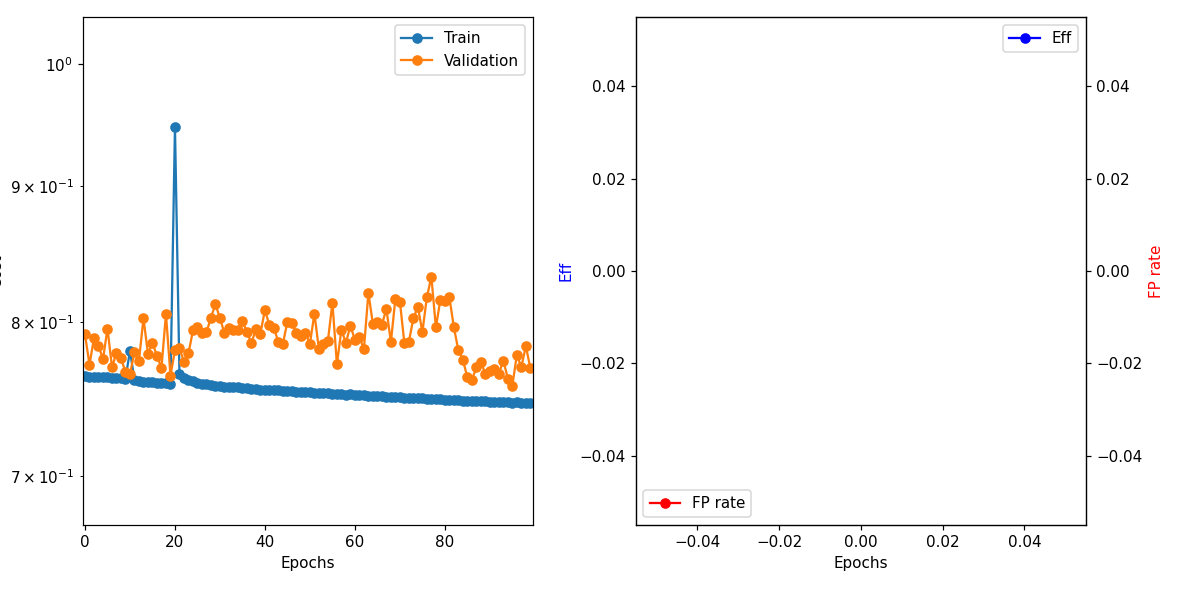

In [18]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [19]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 32079, val = 3125
Number of batches: train = 32079, val = 3125
Epoch 0: train=0.762991, val=0.79116, took 267.31 s
Epoch 1: train=0.762762, val=0.770752, took 236.2 s
Epoch 2: train=0.762821, val=0.788719, took 247.56 s
Epoch 3: train=0.762563, val=0.783321, took 239.11 s
Epoch 4: train=0.762587, val=0.774492, took 248.15 s
Epoch 5: train=0.762215, val=0.795166, took 230.25 s
Epoch 6: train=0.762099, val=0.769094, took 245.25 s
Epoch 7: train=0.761837, val=0.778593, took 240.19 s
Epoch 8: train=0.761777, val=0.774989, took 234.79 s
Epoch 9: train=0.761519, val=0.7658, took 252.11 s


Go ahead and save the final model (even though it was also saved above):

In [20]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [21]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


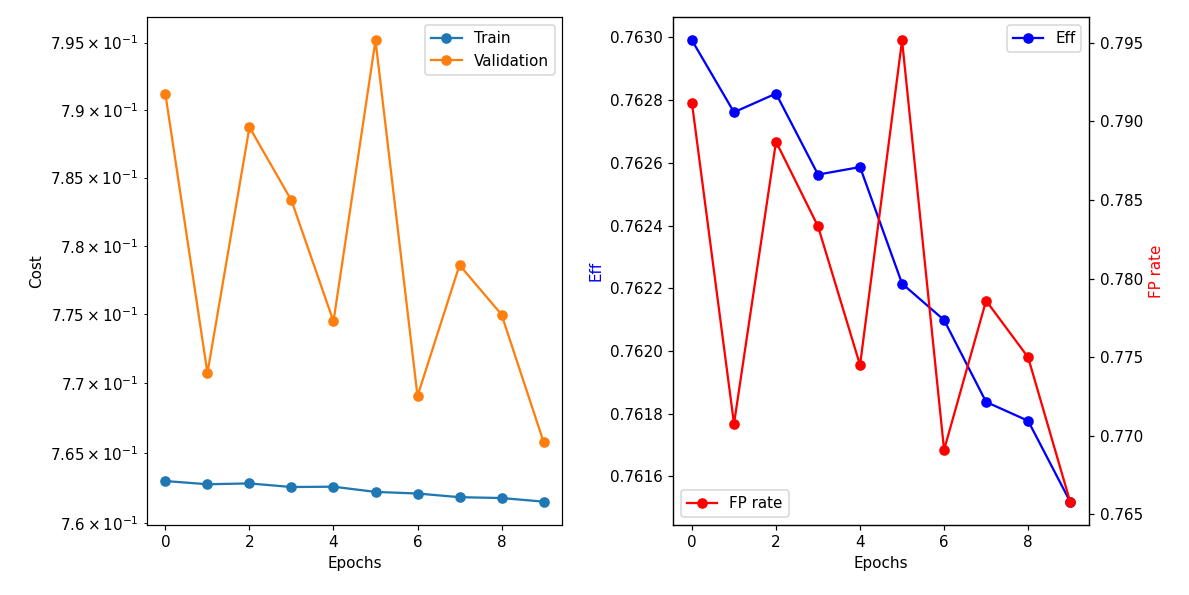

In [22]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [23]:
##quit()


model =  TrackIntervalsToKDE_HalfDozen(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6): Linear(in_features=20, out_features=100, bias=True)
)
model.layer1.weight.shape =  torch.Size([20, 9])


<IPython.core.display.Javascript object>


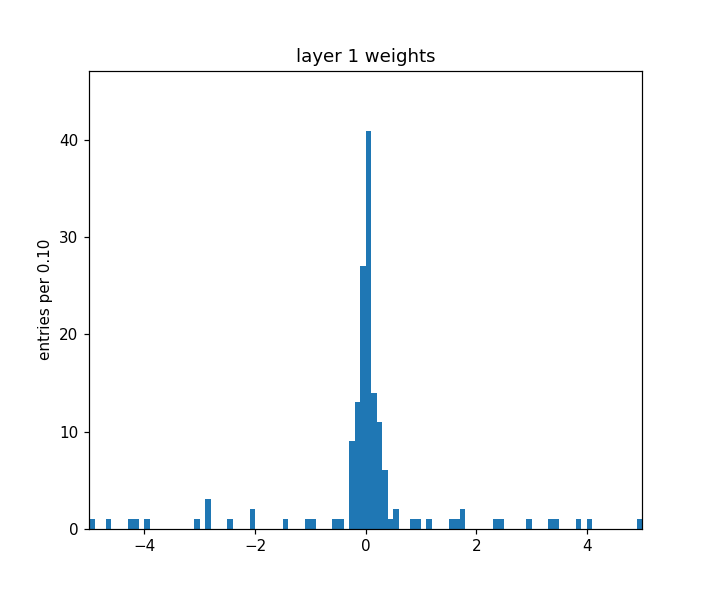

<IPython.core.display.Javascript object>


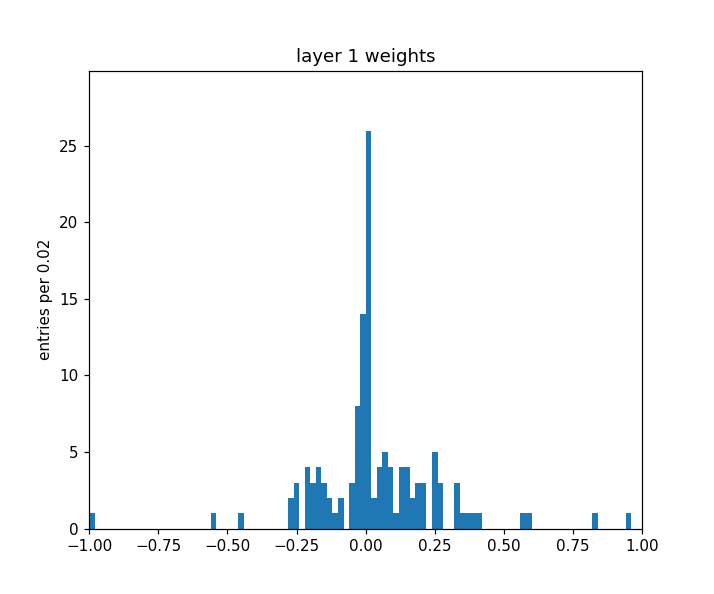

<IPython.core.display.Javascript object>


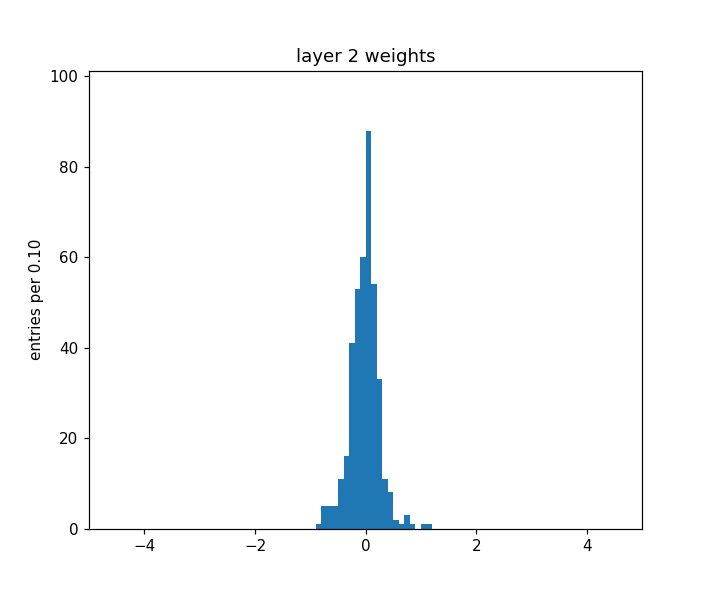

<IPython.core.display.Javascript object>


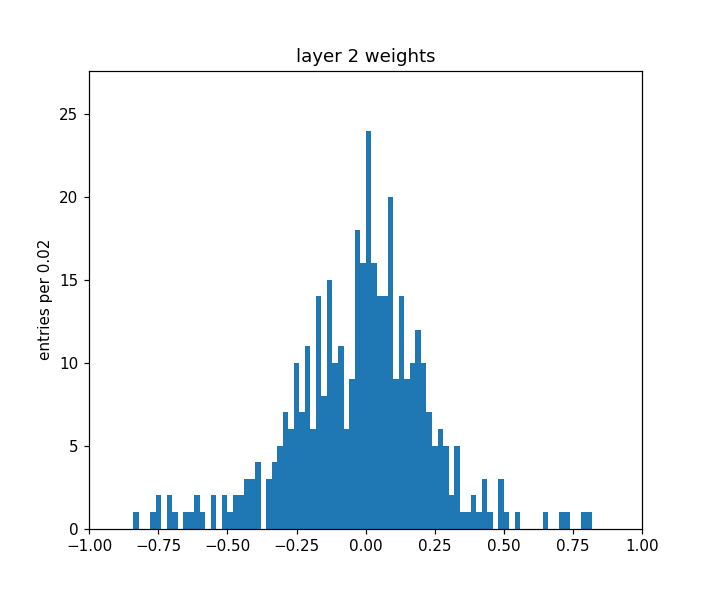

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


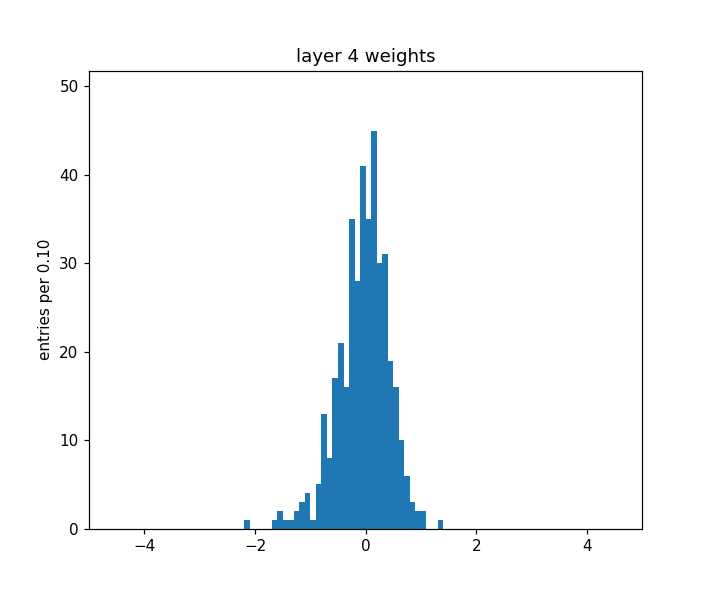

<IPython.core.display.Javascript object>


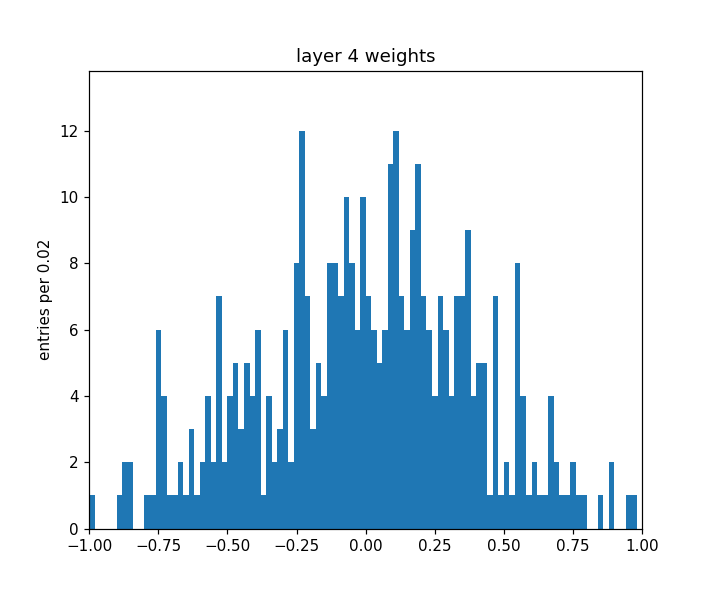

<IPython.core.display.Javascript object>


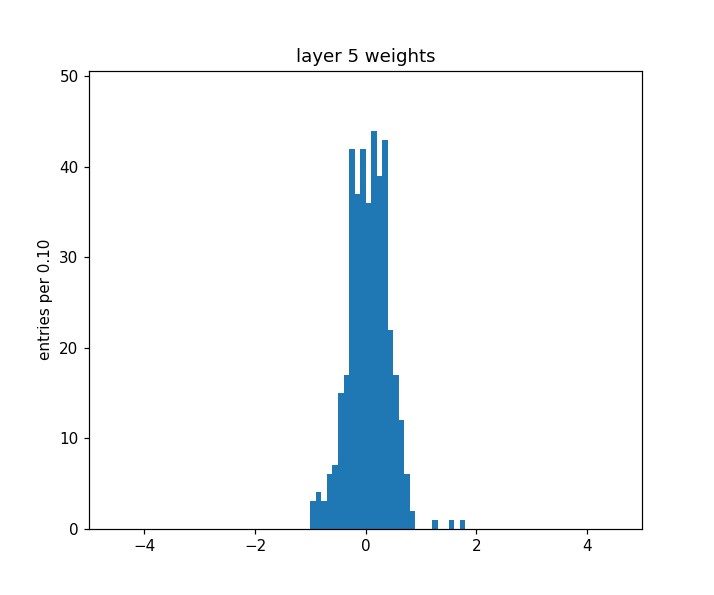

<IPython.core.display.Javascript object>


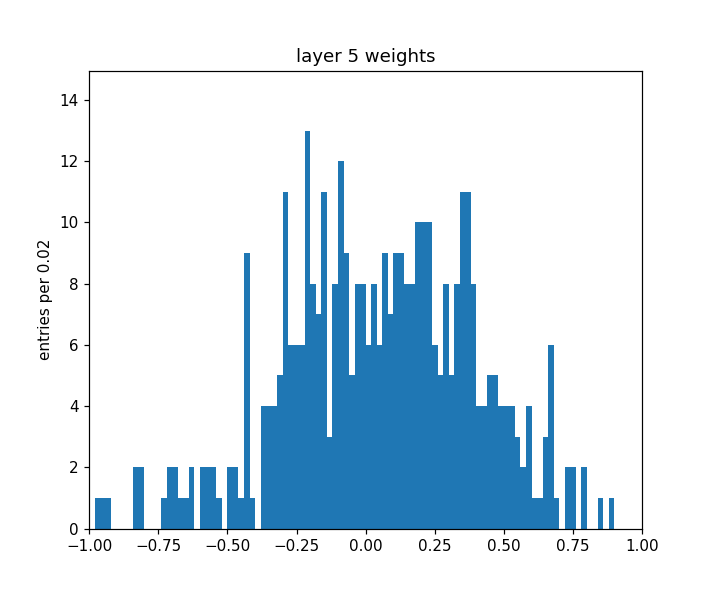

<IPython.core.display.Javascript object>


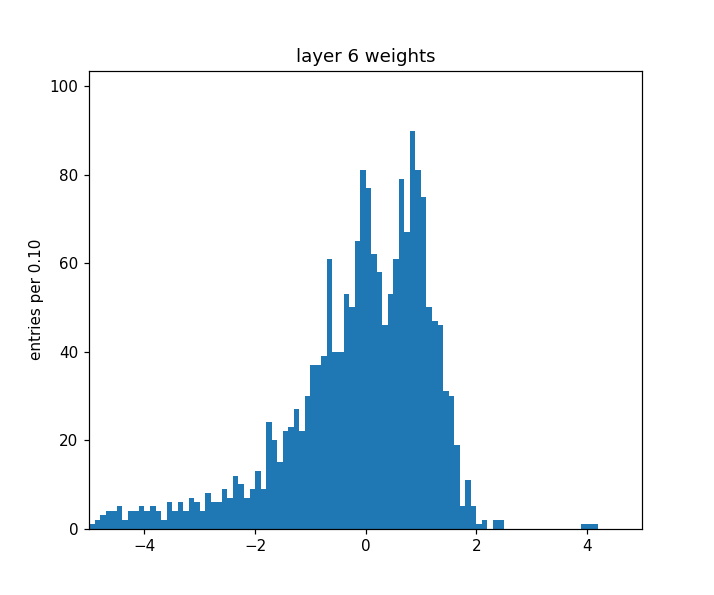

<IPython.core.display.Javascript object>


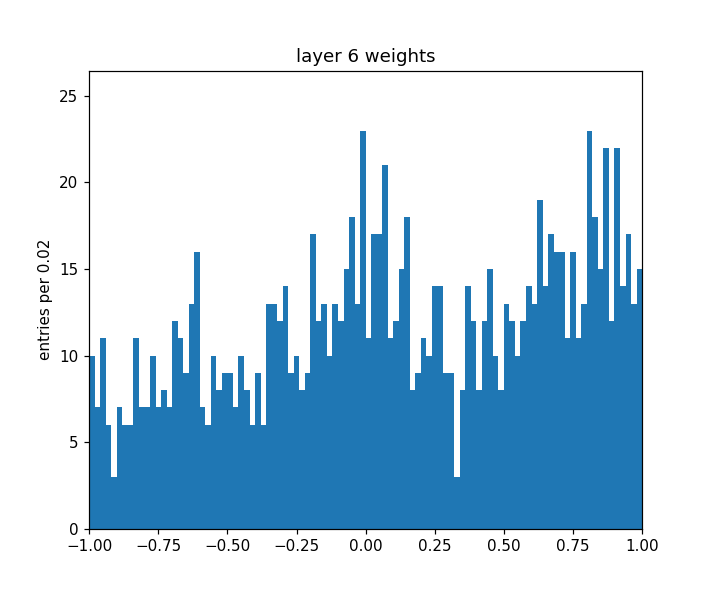

In [24]:
## copied from
##  VScode_RunModel_IntervalTracks_to_KDE_06July2023_HalfDozen_after_iter3B

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


print('model = ',model)
print('model.layer1.weight.shape = ',model.layer1.weight.shape)
weights = model.layer1.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer2.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

### ------------

weights = model.layer3.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer4.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

############## !!!!!!!!!!!!


weights = model.layer5.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer6.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 6 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 6 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()



In [25]:
import torch.nn.utils.prune as prune

In [26]:
module = model.layer2
prune.l1_unstructured(module, name="weight", amount=20)
print('module.weight = ',module.weight)
print('module._forward_pre_hooks.values = ',module._forward_pre_hooks.values)
weights = module.weight.flatten()
weights = weights.cpu()
layer2_weights_posttuning = weights.detach().numpy()


module.weight =  tensor([[-0.1380,  0.1973,  0.1609, -0.0742,  0.0000,  0.0712,  0.0187, -0.1302,
          0.0304,  0.1598, -0.1701,  0.0710, -0.0000,  0.0268,  0.1363, -0.2187,
         -0.1315, -0.2767,  0.0867,  0.0133],
        [-0.1624,  0.4531, -0.0140,  0.1837, -0.1058,  0.0782, -0.0990,  0.1711,
          0.1168, -0.1241, -0.0677,  0.0632,  0.0445, -0.1536, -0.4024,  0.4819,
          1.0121, -0.1984, -0.4142, -0.0000],
        [ 0.1273, -0.2102, -0.1330,  0.2542, -0.0228,  0.0190,  0.0665,  0.1332,
          0.2968,  0.1324,  0.2941, -0.2537,  0.1324, -0.2271,  0.2705,  0.3319,
          0.4380,  0.0679, -0.2483, -0.2164],
        [-0.2540,  0.1526, -0.0000, -0.1327,  0.0805, -0.1027, -0.1241,  0.1724,
          0.1812, -0.0221,  0.1322, -0.0000, -0.0344,  0.2340, -0.0189, -0.0794,
          0.0492, -0.3912,  0.0133,  0.0831],
        [-0.0992, -0.1661,  0.2558, -0.1662, -0.1966, -0.0380, -0.2426, -0.1608,
          0.1733, -0.2468, -0.3926,  0.1428,  0.2590,  0.0122,  0.1736

In [28]:
## let's save the layer 3 weights, pre-pruning
weights = model.layer3.weight.flatten()
weights = weights.cpu()
layer3_weights_pretuning = weights.detach().numpy()

In [29]:
module = model.layer3
prune.l1_unstructured(module, name="weight", amount=20)
print('module.weight = ',module.weight)
print('module._forward_pre_hooks.values = ',module._forward_pre_hooks.values)
weights = module.weight.flatten()
weights = weights.cpu()
layer3_weights_posttuning = weights.detach().numpy()

module.weight =  tensor([[-0.3511, -0.1650,  0.4152, -0.4459,  0.1350, -0.1196, -0.6260,  0.4400,
          0.5125,  0.2509, -0.2412, -0.1979,  0.0335,  1.0654, -0.1029,  0.0312,
         -0.2278, -0.3774,  0.5770,  0.1356],
        [-0.7125,  0.1553, -0.6306, -0.5957, -0.1222, -0.5117,  0.1395, -0.5337,
         -0.1147,  0.7971, -0.0476,  0.0392, -0.2713, -0.6746,  0.4109,  0.1701,
         -0.6287,  0.4981, -0.4309,  0.0445],
        [ 0.5945,  0.0662, -0.3934,  0.2171,  0.0000,  0.0738,  0.5680, -0.1038,
         -0.4331, -0.0473, -0.1253,  0.3105,  0.1973, -0.4145,  0.0955, -0.0331,
          0.0405,  0.0135, -0.2598,  0.3808],
        [-1.7183, -0.3039,  0.0171, -0.5369, -0.0844, -0.7571,  0.3549, -0.0325,
          0.3093, -0.1253,  0.1834, -0.2540, -0.0816, -1.6095,  0.5429,  0.1177,
         -1.0558,  0.3345, -0.4883, -0.0448],
        [-0.4077, -1.0559, -0.4346, -0.3308,  0.3544,  0.2611, -0.6380, -0.2917,
          0.4459, -0.1028, -0.0559,  0.2132, -0.3024, -1.4286, -0.1954

In [30]:
weight_difference = layer3_weights_pretuning - layer3_weights_posttuning
print('weight_difference = ',weight_difference)

weight_difference =  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  1.0821274e-02  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0

In [33]:
module = model.layer4
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer5
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer6
prune.l1_unstructured(module, name="weight", amount=100)

Linear(in_features=20, out_features=100, bias=True)

model =  TrackIntervalsToKDE_HalfDozen(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6): Linear(in_features=20, out_features=100, bias=True)
)
model.layer1.weight.shape =  torch.Size([20, 9])


<IPython.core.display.Javascript object>


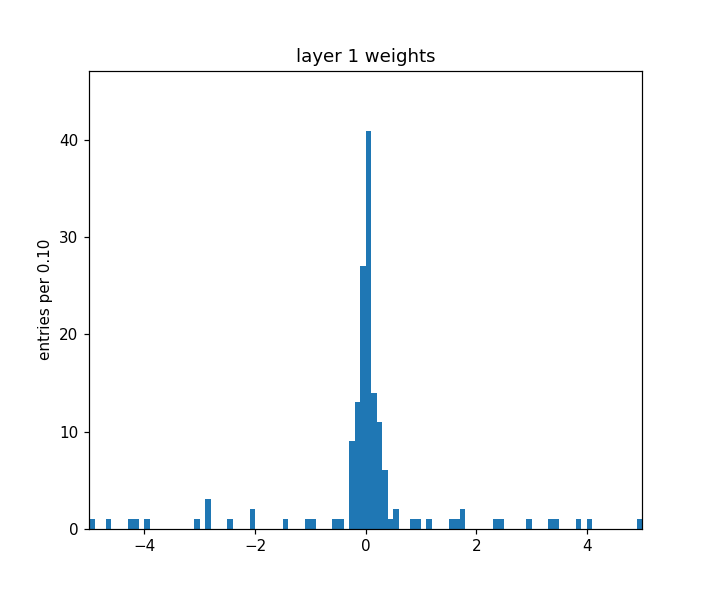

<IPython.core.display.Javascript object>


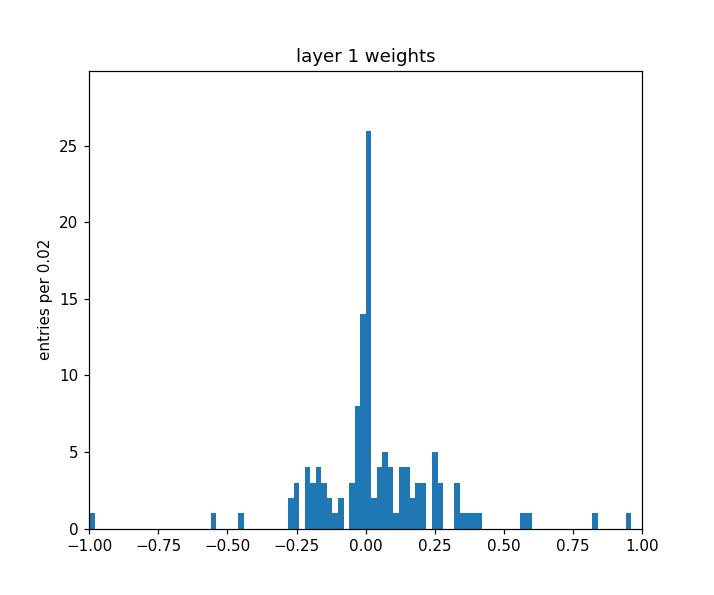

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


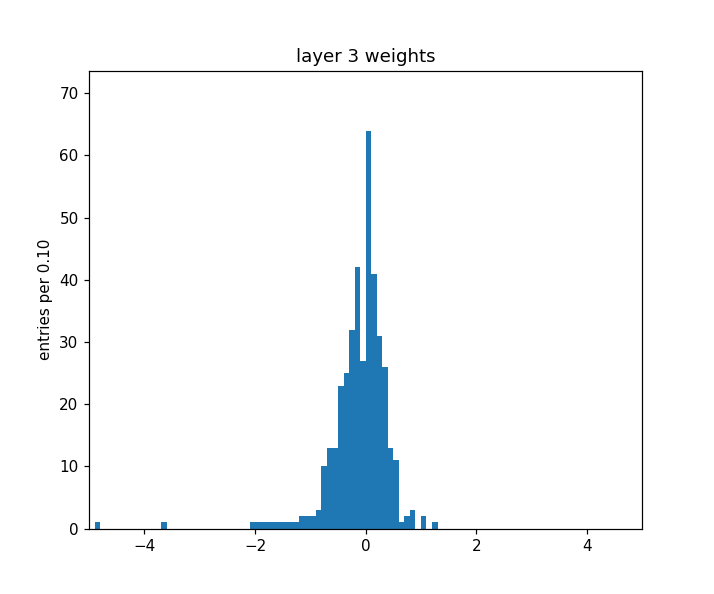

<IPython.core.display.Javascript object>

/tmp/ipykernel_87163/1293995488.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


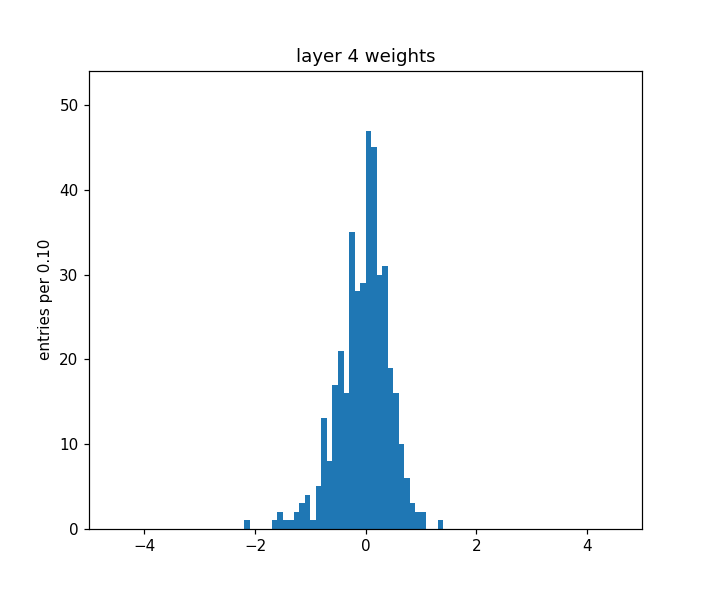

<IPython.core.display.Javascript object>


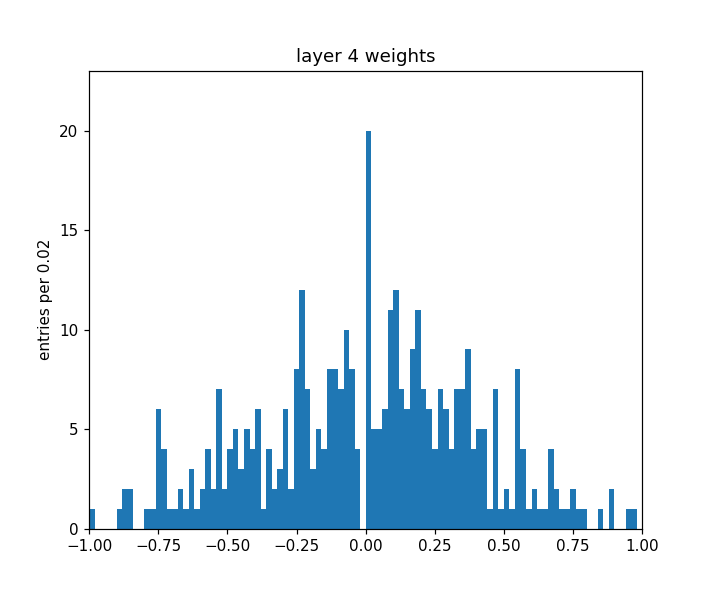

<IPython.core.display.Javascript object>


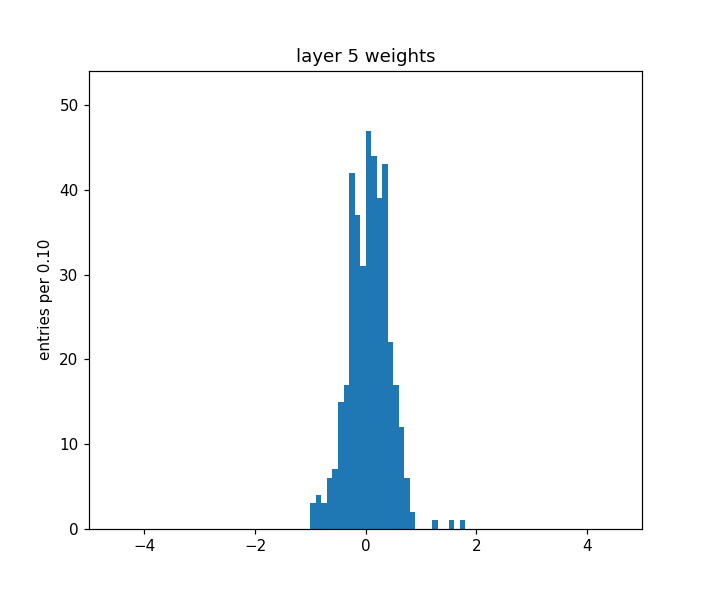

<IPython.core.display.Javascript object>


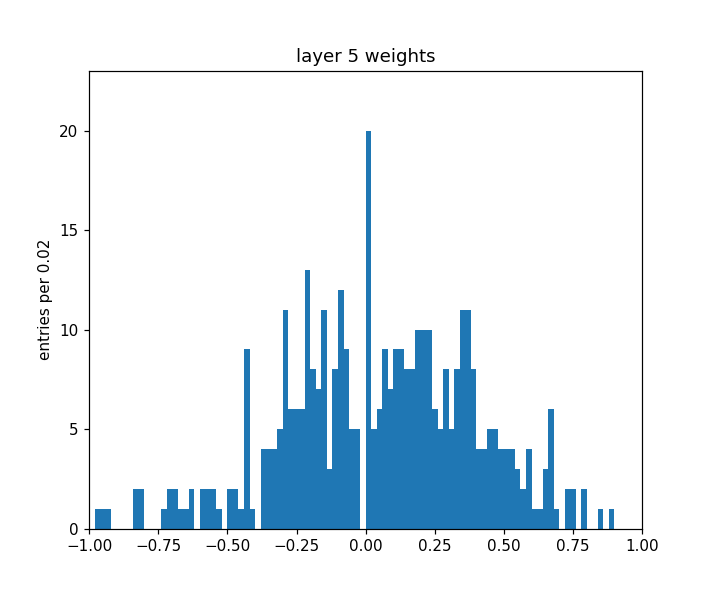

<IPython.core.display.Javascript object>


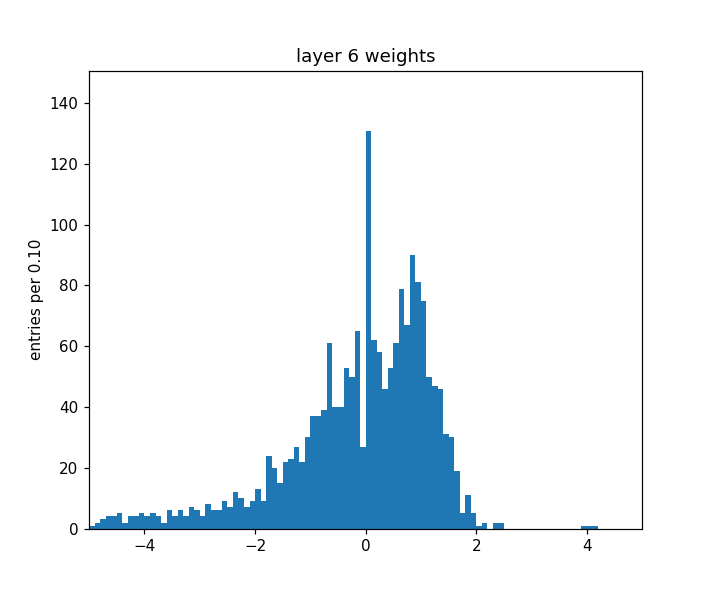

<IPython.core.display.Javascript object>


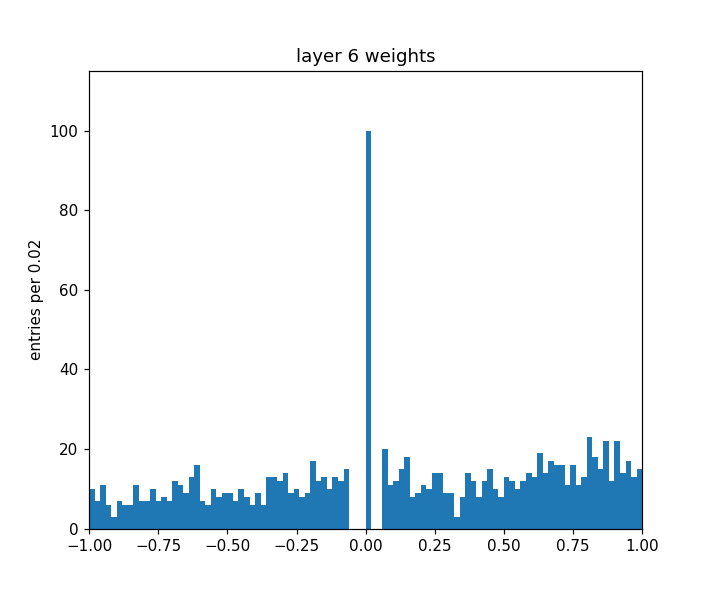

In [34]:
## copied from
##  VScode_RunModel_IntervalTracks_to_KDE_06July2023_HalfDozen_after_iter3B

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size


print('model = ',model)
print('model.layer1.weight.shape = ',model.layer1.weight.shape)
weights = model.layer1.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 1 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer2.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 2 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

### ------------

weights = model.layer3.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 3 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer4.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 4 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

############## !!!!!!!!!!!!


weights = model.layer5.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 5 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()

######## ---------

weights = model.layer6.weight.flatten()
weights = weights.cpu()
weights = weights.detach().numpy()


plt.figure()
plt.title('layer 6 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-5.,5.))
plt.ylabel('entries per 0.10')
plt.axis([-5.,5.,0.,1.15*max(nC)])
plt.show()


plt.figure()
plt.title('layer 6 weights')
nC, bins, patches = plt.hist(weights,bins=100,range=(-1.,1.))
plt.ylabel('entries per 0.02')
plt.axis([-1.,1.,0.,1.15*max(nC)])
plt.show()



In [36]:
## replace n_epochs with 20 with train for an additional 10 epochs

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        20, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 32079, val = 3125
Number of batches: train = 32079, val = 3125
Epoch 10: train=0.779984, val=0.764415, took 253.41 s
Epoch 11: train=0.760743, val=0.779294, took 247.33 s
Epoch 12: train=0.760061, val=0.773482, took 252.9 s
Epoch 13: train=0.759533, val=0.802413, took 245.33 s
Epoch 14: train=0.759278, val=0.778054, took 242.42 s
Epoch 15: train=0.758912, val=0.785307, took 250.48 s
Epoch 16: train=0.758755, val=0.776606, took 248.54 s
Epoch 17: train=0.758479, val=0.768604, took 253.93 s
Epoch 18: train=0.758328, val=0.805287, took 256.84 s
Epoch 19: train=0.758057, val=0.763503, took 246.31 s


In [37]:
module = model.layer2
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer3
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer4
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer5
prune.l1_unstructured(module, name="weight", amount=20)

module = model.layer6
prune.l1_unstructured(module, name="weight", amount=100)

Linear(in_features=20, out_features=100, bias=True)

In [38]:
## replace n_epochs with 100 with train for an additional 80 epochs

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        100, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 32079, val = 3125
Number of batches: train = 32079, val = 3125
Epoch 20: train=0.946751, val=0.780444, took 255.45 s
Epoch 21: train=0.764786, val=0.781876, took 258.01 s
Epoch 22: train=0.761889, val=0.772697, took 254.15 s
Epoch 23: train=0.760496, val=0.778234, took 255.66 s
Epoch 24: train=0.759602, val=0.793929, took 242.81 s
Epoch 25: train=0.758802, val=0.79598, took 249.57 s
Epoch 26: train=0.75805, val=0.79239, took 244.02 s
Epoch 27: train=0.757648, val=0.792581, took 254.92 s
Epoch 28: train=0.757213, val=0.802872, took 253.28 s
Epoch 29: train=0.756866, val=0.81211, took 250.16 s
Epoch 30: train=0.756511, val=0.802443, took 261.14 s
Epoch 31: train=0.756284, val=0.792046, took 251.09 s
Epoch 32: train=0.755994, val=0.795283, took 252.95 s
Epoch 33: train=0.755866, val=0.794035, took 252.32 s
Epoch 34: train=0.755685, val=0.793914, took 256.56 s
Epoch 35: train=0.755324, val=0.800144, took 248.79 s
Epoch 36: train=0.755153, val=0.793131, took 252.0

<IPython.core.display.Javascript object>


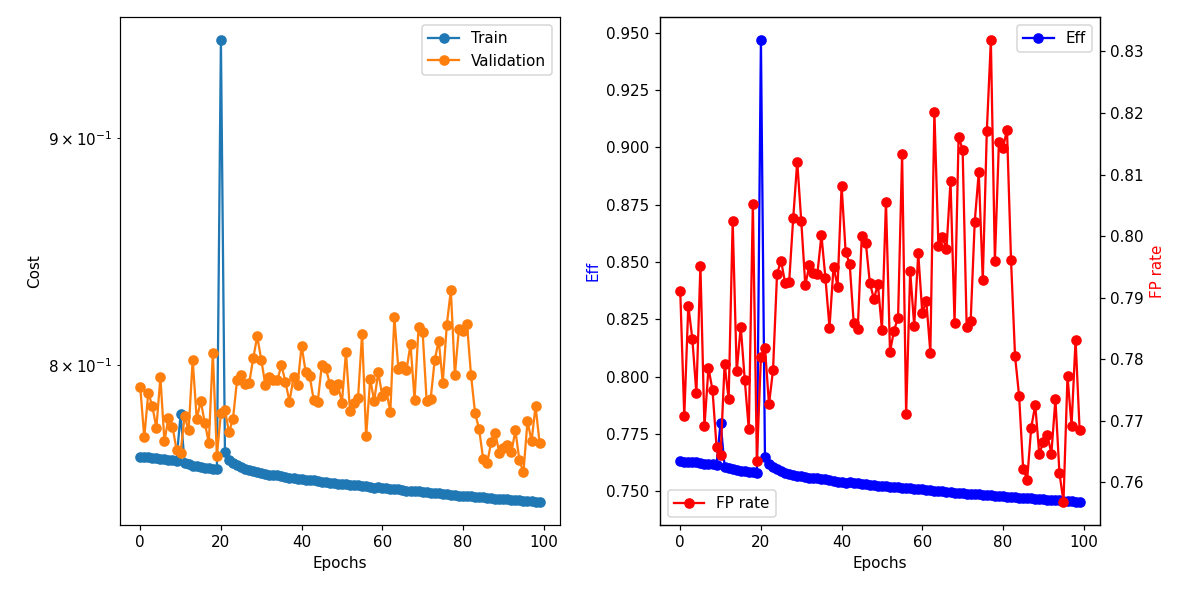

In [39]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

<IPython.core.display.Javascript object>


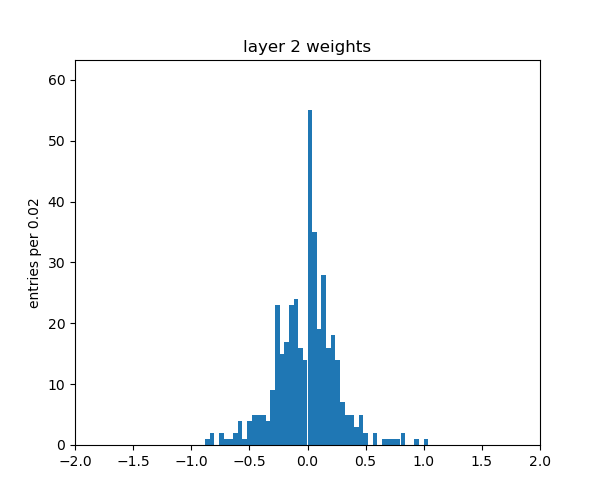

<IPython.core.display.Javascript object>


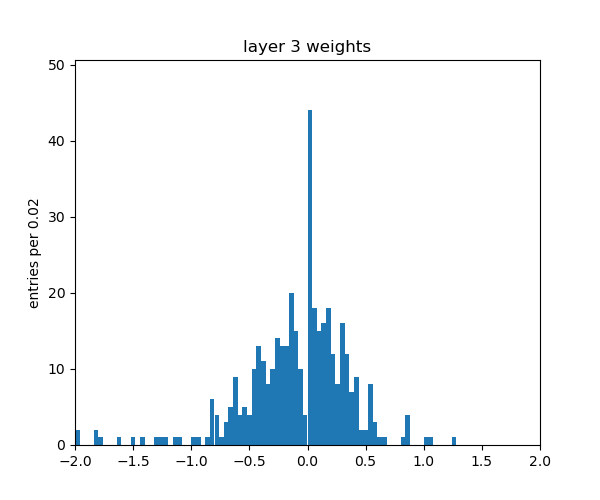

<IPython.core.display.Javascript object>


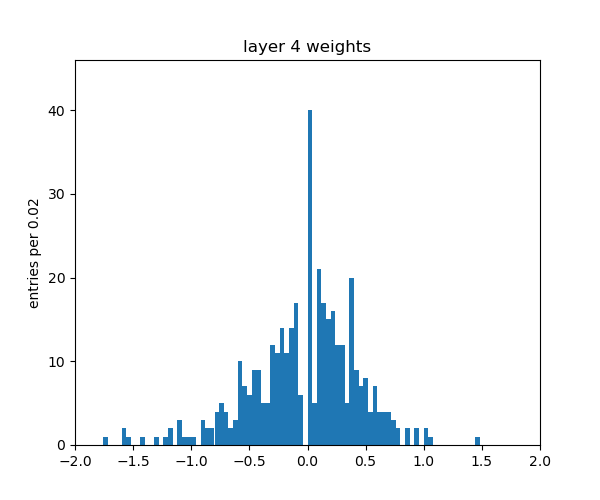

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
for index, module in enumerate([ model.layer2, model.layer3,  model.layer4, model.layer5, model.layer6]):
    plt.figure()
    plt.title('layer '+str(index+2)+' weights')
    weights = module.weight.flatten()
    weights = weights.cpu()
    weights = weights.detach().numpy()
    nC, bins, patches = plt.hist(weights,bins=100,range=(-2.,2.))
    plt.ylabel('entries per 0.02')
    plt.axis([-2.,2.,0.,1.15*max(nC)])
    plt.show()
    prune.remove(module, 'weight')
    
    

In [46]:
## save the pruned model

torch.save(model.state_dict(), output / f'{name}_final.pyt')